In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, recall_score
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

from tabulate import tabulate

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import joblib

from sklearn.model_selection import learning_curve

### Carga de Dataset

In [20]:
# Cargar el dataset
file_path = '../data/processed/df_pre-encoded.csv'
#file_path = '../data/processed/df_cancer_prostata_processed.csv'
df = pd.read_csv(file_path)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 47 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   RELIGION1                                   2644 non-null   object 
 1   COMUNA                                      2644 non-null   object 
 2   REGION                                      2644 non-null   object 
 3   SSREFERENCIA                                2644 non-null   object 
 4   RECINTO_PROCEDE                             2644 non-null   object 
 5   ESTABLE_DESTINO                             2644 non-null   object 
 6   SITUACION_LABORAL                           2644 non-null   object 
 7   ULT_CURSO_APROBADO                          2644 non-null   object 
 8   CANCER_PREVIO_1                             2644 non-null   object 
 9   CANCER_PREVIO_2                             2644 non-null   object 
 10  PARENTESCO_1

### Devide los datos en conjuntos de entrenamiento, validacón y prueba, Con Balanceo de Clases

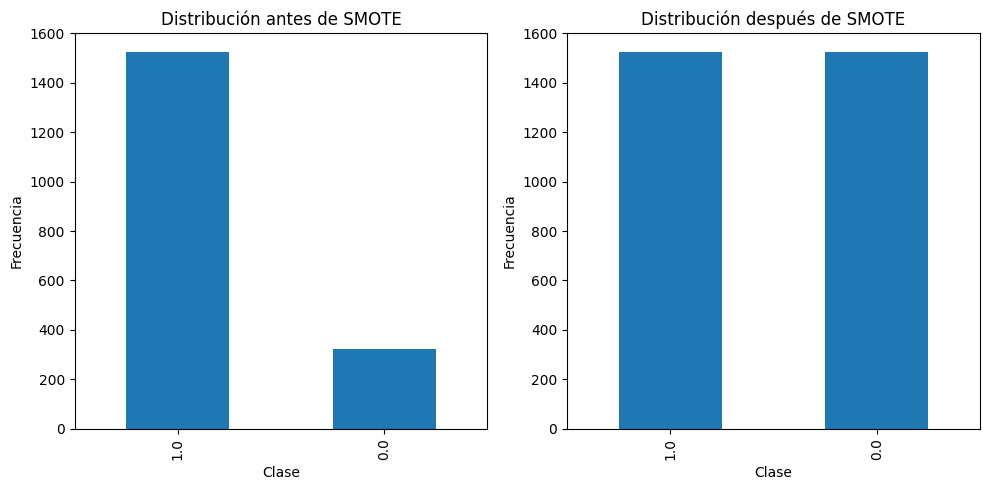

In [22]:

# Seleccionar características y la variable objetivo
X = df.drop(columns=['SOBREVIVE'])
y = df['SOBREVIVE']

# Convertir las variables categóricas a variables dummy
X = pd.get_dummies(X, drop_first=True)

# Divide los datos en conjuntos de entrenamiento, validación y prueba (70% entrenamiento, 15% validación, 15% prueba)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Dividir los datos en conjuntos de entrenamiento y prueba
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Visualizar la distribución antes de aplicar SMOTE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', title='Distribución antes de SMOTE')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')

# Aplicar SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Visualizar la distribución después de aplicar SMOTE
plt.subplot(1, 2, 2)
y_train_balanced.value_counts().plot(kind='bar', title='Distribución después de SMOTE')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Estandarizar los datos
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)
X_test = scaler.transform(X_test)



### Funciones

In [23]:

def format_classification_report(report_items,modelo_name):
    # Formatear el reporte para tabulate
    report_table = []

    for label, metrics in report_items:
        if isinstance(metrics, dict):
            row = [label]
            row.extend([metrics['precision'], metrics['recall'], metrics['f1-score'], metrics['support']])
            report_table.append(row)
        else:
            row = [label, metrics]
            report_table.append(row)

    headers = ["Class", "Precision", "Recall", "F1-Score", "Support"]
    
    print(f"Classification Report for {modelo_name}")
    # Imprimir el reporte con tabulate
    print(tabulate(report_table, headers=headers, tablefmt="grid"))
    
# Función para entrenar y evaluar modelos
def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    return accuracy, report, y_pred


def display_best_params_and_score(best_params_items, best_score, modelo_name):
    # Convertir best_params en una lista de listas para tabular
    params_table = [[key, value] for key, value in best_params_items]
    
    print(f"\nMejores Hiperparámetros para {modelo_name}:")

    # Imprimir best_params con tabulate
    print(tabulate(params_table, headers=["Hiperparámetro", "Mejor Valor"]))

    # Mostrar el mejor score
    print(f"\nMejor Score: {best_score}")
    
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy'
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

### Modelos de Clasificación

In [24]:
# Entrenar y evaluar el modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_accuracy, rf_report, y_pred_rf = train_evaluate_model(rf_model, X_train_balanced, y_train_balanced, X_test, y_test)

# Entrenar y evaluar el modelo SVM
svm_model = SVC(random_state=42)
svm_accuracy, svm_report, y_pred_svm = train_evaluate_model(svm_model, X_train_balanced, y_train_balanced, X_test, y_test)

# Crear el modelo KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_accuracy, knn_report, y_pred_knn = train_evaluate_model(knn_model, X_train_balanced, y_train_balanced, X_test, y_test)

# Entrenamiento del modelo XGBoost
xgb_model = XGBClassifier()
xgb_accuracy, xgb_report, y_pred_xgb = train_evaluate_model(xgb_model, X_train_balanced, y_train_balanced, X_test, y_test)


# Imprimir los resultados
print("Random Forest Accuracy:", rf_accuracy)
print("SVM Accuracy:", svm_accuracy)
print("KNN Accuracy:", knn_accuracy)
print("XGBoost Accuracy:", xgb_accuracy)


Random Forest Accuracy: 0.8740554156171285
SVM Accuracy: 0.8992443324937027
KNN Accuracy: 0.836272040302267
XGBoost Accuracy: 0.8841309823677582


In [25]:
#Imprimir reporte de clasificación
format_classification_report(knn_report.items(),'KNN')
format_classification_report(rf_report.items(),'Random Forest')
format_classification_report(svm_report.items(),'SVM')
format_classification_report(xgb_report.items(),'XGBoost')

Classification Report for KNN
+--------------+-------------+----------+------------+-----------+
| Class        |   Precision |   Recall |   F1-Score |   Support |
+==============+=============+==========+============+===========+
| 0.0          |    0.54902  | 0.4      |   0.46281  |        70 |
+--------------+-------------+----------+------------+-----------+
| 1.0          |    0.878613 | 0.929664 |   0.903418 |       327 |
+--------------+-------------+----------+------------+-----------+
| accuracy     |    0.836272 |          |            |           |
+--------------+-------------+----------+------------+-----------+
| macro avg    |    0.713816 | 0.664832 |   0.683114 |       397 |
+--------------+-------------+----------+------------+-----------+
| weighted avg |    0.820498 | 0.836272 |   0.825729 |       397 |
+--------------+-------------+----------+------------+-----------+
Classification Report for Random Forest
+--------------+-------------+----------+------------+-----

### Matriz de Confusión 

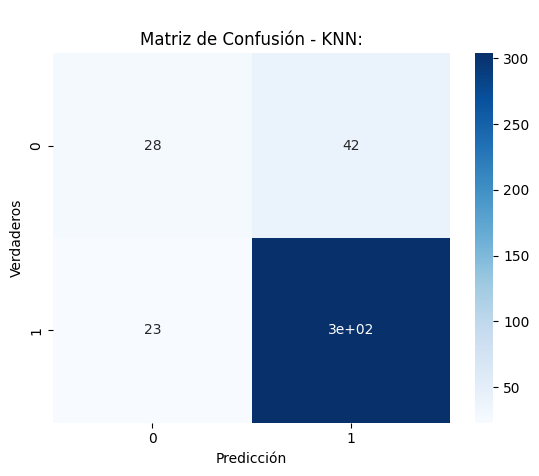

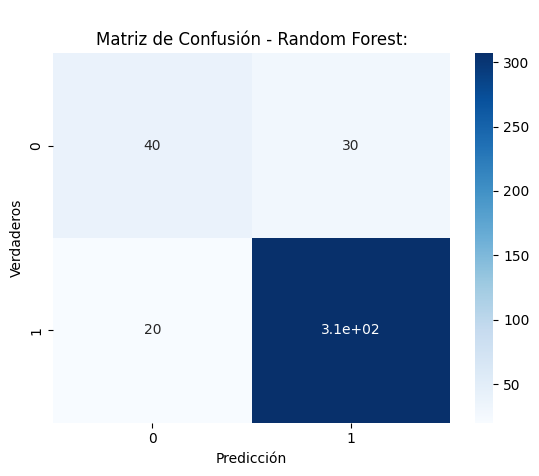

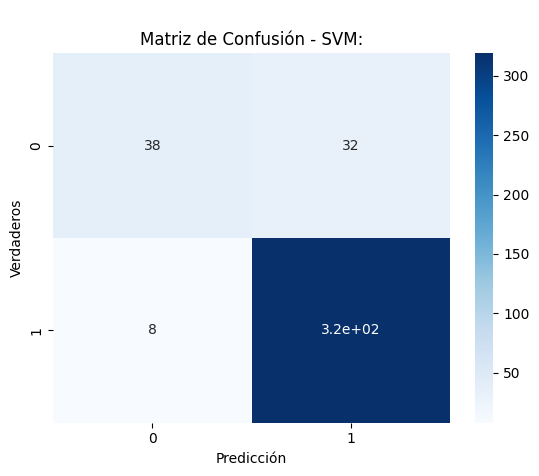

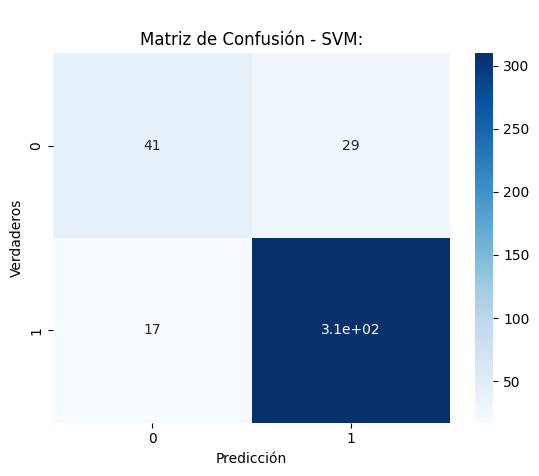

In [26]:
# Matriz de confusión para cada clasificador
cm1 = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm1, annot=True, cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Verdaderos")
plt.title("\nMatriz de Confusión - KNN:")
plt.show()

# Matriz de confusión para cada clasificador
cm2 = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm2, annot=True, cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Verdaderos")
plt.title("\nMatriz de Confusión - Random Forest:")
plt.show()

# Matriz de confusión para cada clasificador
cm3 = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm3, annot=True, cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Verdaderos")
plt.title("\nMatriz de Confusión - SVM:")
plt.show()

# Matriz de confusión para cada clasificador
cm4 = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm4, annot=True, cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Verdaderos")
plt.title("\nMatriz de Confusión - SVM:")
plt.show()

### Hiperparametros con GridSearch

In [27]:

# GridSearchCV para KNN
knn_params = {'n_neighbors': [3, 5, 7, 9, 11]}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='f1', n_jobs=-1)
knn_grid.fit(X_train_balanced, y_train_balanced)
best_knn = knn_grid.best_params_
knn_best_score = knn_grid.best_score_

# Guardar el modelo entrenado
joblib.dump(knn_grid.best_estimator_, '../models/cancer_survival_model-knn_bal.pkl')

# GridSearchCV para Random Forest
rf_params = {
    'n_estimators': [50,100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Configurar GridSearchCV
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='f1', n_jobs=-1)
# Ejecutar la búsqueda de hiperparámetros
rf_grid.fit(X_train_balanced, y_train_balanced)

# Obtener los mejores hiperparámetros y el mejor score
best_rf = rf_grid.best_params_
rf_best_score = rf_grid.best_score_

# Guardar el modelo entrenado
joblib.dump(rf_grid.best_estimator_, '../models/cancer_survival_model-rf_bal.pkl')

# GridSearchCV para SVM
# Definir los hiperparámetros a buscar
svm_params = {
    'C': [10, 100],
    'gamma': [ 0.001, 0.01, 'scale', 'auto']
}
svm_params = {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto']}
svm_grid = GridSearchCV(SVC(kernel='linear', random_state=42), svm_params, cv=5, scoring='f1')
svm_grid.fit(X_train_balanced, y_train_balanced)
best_svm = svm_grid.best_params_
svm_best_score = svm_grid.best_score_

# Guardar el modelo entrenado
joblib.dump(svm_grid.best_estimator_, '../models/cancer_survival_model-svm_bal.pkl')

# Definir los hiperparámetros para la búsqueda aleatoria para XGBoost
xgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Configurar RandomizedSearchCV para XGBoost
xgb_random = RandomizedSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), 
    xgb_params, 
    cv=3, 
    scoring='f1', 
    n_jobs=2, 
    n_iter=10,  # Número de combinaciones de parámetros a probar
    random_state=42
)

# Ejecutar la búsqueda de hiperparámetros para XGBoost
xgb_random.fit(X_train_balanced, y_train_balanced)

# Obtener los mejores hiperparámetros y el mejor score para XGBoost de la búsqueda aleatoria
best_xgb_random = xgb_random.best_params_
xgb_random_best_score = xgb_random.best_score_

# Imprimir los mejores parámetros y scores de la búsqueda aleatoria
#print("Best Random Search XGBoost params:", best_xgb_random, "with score:", xgb_random_best_score)

# Ahora realiza una búsqueda más fina alrededor de los mejores parámetros obtenidos de la búsqueda aleatoria
xgb_fine_params = {
    'n_estimators': np.arange(best_xgb_random['n_estimators']-20, best_xgb_random['n_estimators']+20, 10),
    'max_depth': [best_xgb_random['max_depth']-1, best_xgb_random['max_depth'], best_xgb_random['max_depth']+1],
    'learning_rate': [best_xgb_random['learning_rate']*0.5, best_xgb_random['learning_rate'], best_xgb_random['learning_rate']*1.5],
    'subsample': [max(0.1, best_xgb_random['subsample']-0.1), best_xgb_random['subsample'], min(1.0, best_xgb_random['subsample']+0.1)],
    'colsample_bytree': [max(0.1, best_xgb_random['colsample_bytree']-0.1), best_xgb_random['colsample_bytree'], min(1.0, best_xgb_random['colsample_bytree']+0.1)]
}

# Configurar GridSearchCV para XGBoost con un espacio de búsqueda más fino
xgb_grid = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), 
    xgb_fine_params, 
    cv=3, 
    scoring='f1', 
    n_jobs=2
)

# Ejecutar la búsqueda de hiperparámetros más fina para XGBoost
xgb_grid.fit(X_train_balanced, y_train_balanced)

# Obtener los mejores hiperparámetros y el mejor score para XGBoost de la búsqueda en cuadrícula fina
best_xgb = xgb_grid.best_params_
xgb_best_score = xgb_grid.best_score_

# Guardar el modelo entrenado para XGBoost
joblib.dump(xgb_grid.best_estimator_, '../models/cancer_survival_model-XGBoost_bal.pkl')

['../models/cancer_survival_model-XGBoost_bal.pkl']

### Informes de Resultados Optimización Hiperparametros

In [28]:
# Mostrar los mejores hiperparámetros y el mejor score
display_best_params_and_score(best_knn.items(), knn_best_score, 'KNN')
display_best_params_and_score(best_rf.items(), rf_best_score,'Radom Forest')
display_best_params_and_score(best_svm.items(), svm_best_score,'SVM')
display_best_params_and_score(best_xgb.items(), xgb_best_score,'XGBoost')



Mejores Hiperparámetros para KNN:
Hiperparámetro      Mejor Valor
----------------  -------------
n_neighbors                   3

Mejor Score: 0.9142734276530782

Mejores Hiperparámetros para Radom Forest:
Hiperparámetro       Mejor Valor
-----------------  -------------
max_depth                     20
min_samples_leaf               1
min_samples_split              5
n_estimators                 300

Mejor Score: 0.9364555822074774

Mejores Hiperparámetros para SVM:
Hiperparámetro    Mejor Valor
----------------  -------------
C                 0.1
gamma             scale

Mejor Score: 0.9098316491025461

Mejores Hiperparámetros para XGBoost:
Hiperparámetro      Mejor Valor
----------------  -------------
colsample_bytree          0.7
learning_rate             0.015
max_depth                10
n_estimators            200
subsample                 0.6

Mejor Score: 0.9244341728790264


### Procederemos a generar curvas de aprendizaje para los tres modelos: KNN, Random Forest, SVM y XGBoost



Classification Report for KNN
+--------------+-------------+----------+------------+-----------+
| Class        |   Precision |   Recall |   F1-Score |   Support |
+==============+=============+==========+============+===========+
| 0.0          |    0.5      | 0.357143 |   0.416667 |        70 |
+--------------+-------------+----------+------------+-----------+
| 1.0          |    0.870317 | 0.923547 |   0.896142 |       327 |
+--------------+-------------+----------+------------+-----------+
| accuracy     |    0.823678 |          |            |           |
+--------------+-------------+----------+------------+-----------+
| macro avg    |    0.685159 | 0.640345 |   0.656405 |       397 |
+--------------+-------------+----------+------------+-----------+
| weighted avg |    0.805022 | 0.823678 |   0.8116   |       397 |
+--------------+-------------+----------+------------+-----------+
Classification Report for Random Forest
+--------------+-------------+----------+------------+-----

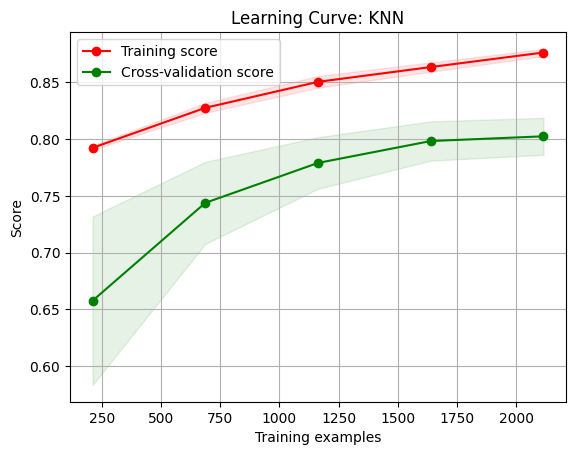

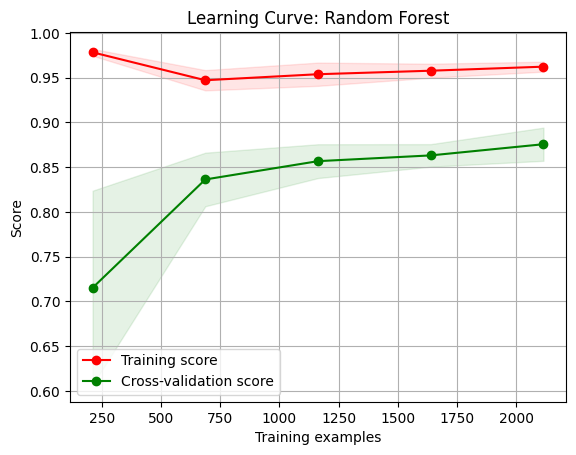

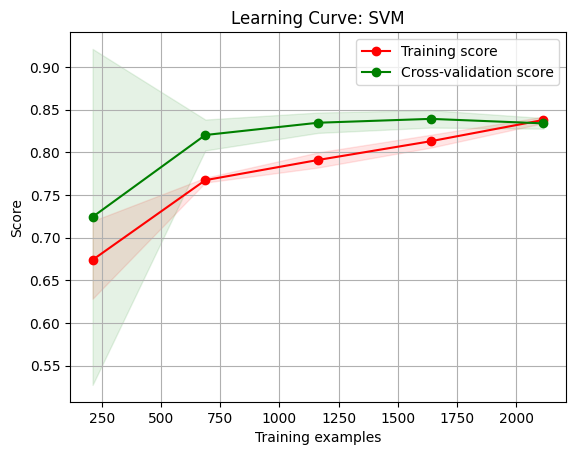

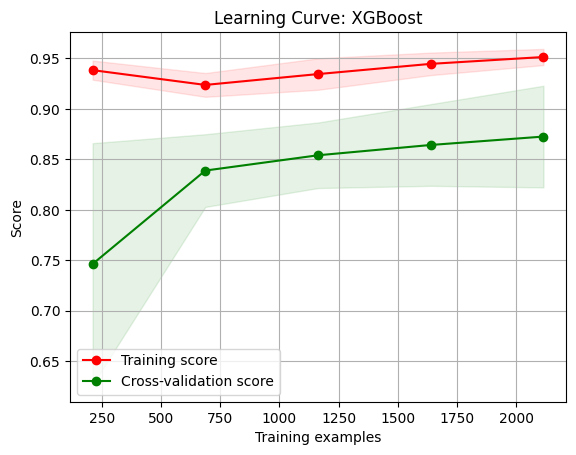

In [29]:
# Cargar el mejor modelo de XGBoost desde el archivo
best_knn_model = joblib.load('../models/cancer_survival_model-knn_bal.pkl')
best_rf_model = joblib.load('../models/cancer_survival_model-rf_bal.pkl')
best_svm_model = joblib.load('../models/cancer_survival_model-svm_bal.pkl')
best_xgb_model = joblib.load('../models/cancer_survival_model-XGBoost_bal.pkl')

best_y_pred_knn = best_knn_model.predict(X_test)
best_y_pred_rf = best_rf_model.predict(X_test)
best_y_pred_svm = best_svm_model.predict(X_test)
best_y_pred_xgb = best_xgb_model.predict(X_test)

report_best_knn = classification_report(y_test, best_y_pred_knn, output_dict=True)
report_best_rf = classification_report(y_test, best_y_pred_rf, output_dict=True)
report_best_svm = classification_report(y_test, best_y_pred_svm, output_dict=True)
report_best_xgb = classification_report(y_test, best_y_pred_xgb, output_dict=True)

#Imprimir reporte de clasificación
format_classification_report(report_best_knn.items(),'KNN')
format_classification_report(report_best_rf.items(),'Random Forest')
format_classification_report(report_best_svm.items(),'SVM')
format_classification_report(report_best_xgb.items(),'XGBoost')

# Generar la curva de aprendizaje para el modelo de XGBoost
plot_learning_curve(best_knn_model, "Learning Curve: KNN", X, y, cv=5)
plot_learning_curve(best_rf_model, "Learning Curve: Random Forest", X, y, cv=5)
plot_learning_curve(best_svm_model, "Learning Curve: SVM", X, y, cv=5)
plot_learning_curve(best_xgb_model, "Learning Curve: XGBoost", X, y, cv=5)
plt.show()


### Características más importantes Random Forest

In [30]:
# Obtener las características más importantes
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Seleccionar las 10 características más importantes
top_features_indices = indices[:10]
top_features_importances = importances[top_features_indices]
top_features_names = X_train.columns[top_features_indices]

# Crear un DataFrame para visualizar las importancias
feature_importance_df = pd.DataFrame({
    'Feature': top_features_names,
    'Importance': top_features_importances
})

feature_importance_df


,Feature,Importance
0,RESPUESTA_TRATA_Enfermedad Progresiva,0.063007
1,INTENCION_TRATA_Paliativo,0.055121
2,EXTENSION_NOM_Metástasis,0.049302
3,M_M1,0.042743
4,N_NX,0.038468
5,ETAPA_CLINICA_IV,0.036234
6,T_TX,0.024461
7,REGION_REGION DE LOS RIOS,0.020425
8,CANCER_PARENTESCO_2_Sin Informacion,0.020067
9,GRADO_DIFERENCIACION_Poco Diferenciado,0.019907


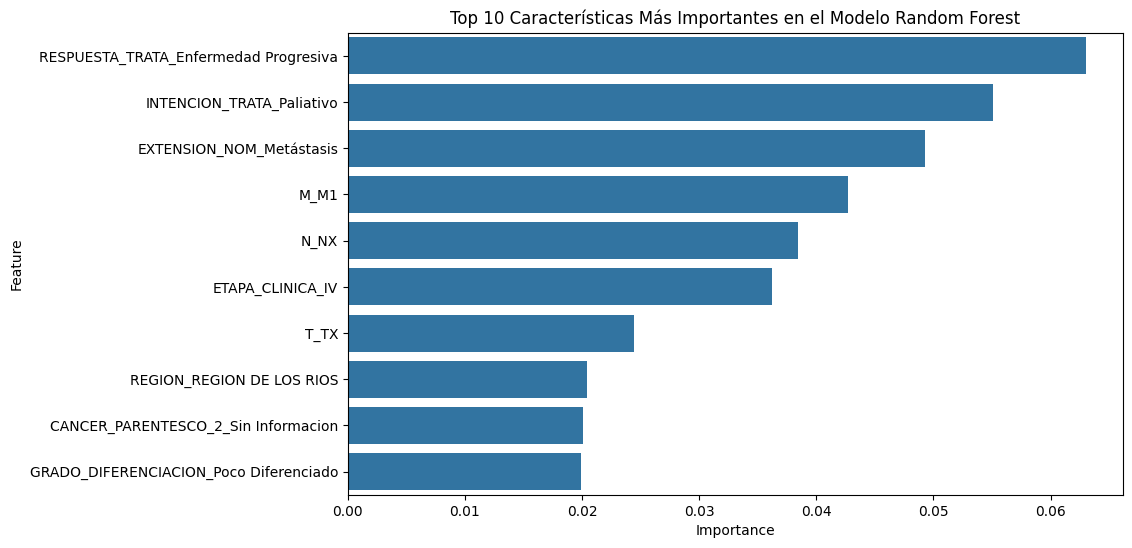

In [31]:
# Visualización de la importancia de las características
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Top 10 Características Más Importantes en el Modelo Random Forest')
plt.show()

